# Natural Language Processing CA3

## Ali Khoramfar
## 810102129

In [47]:
import numpy as np
import json
import matplotlib.pyplot as plt
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/train.json'

with open(file_path, 'r') as file:
    train_data = json.load(file)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/valid.json'

with open(file_path, 'r') as file:
    valid_data = json.load(file)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/test.json'

with open(file_path, 'r') as file:
    test_data = json.load(file)

#Part 1

##Convert Labels from Text to Numerical

In [4]:
labels = {
    'O': 0, 'B-ARG0': 1, 'I-ARG0': 2, 'B-ARG1': 3, 'I-ARG1': 4, 'B-ARG2': 5, 'I-ARG2': 6, 'B-ARGM-LOC': 7, 'I-ARGM-LOC': 8, 'B-ARGM-TMP': 9, 'I-ARGM-TMP': 10
}

def convert_labels(srl_frames):
    converted_srl_frames = []
    for frame in srl_frames:
        converted_frame = [labels[label] for label in frame]
        converted_srl_frames.append(converted_frame)
    return converted_srl_frames


train_data['srl_frames'] = convert_labels(train_data['srl_frames'])
valid_data['srl_frames'] = convert_labels(valid_data['srl_frames'])

print(train_data['srl_frames'][1])

[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]


##Padding Function

In [5]:
def pad_text_and_labels(sentences, labels, max_length, padding_token='<pad>', label_pad_index=0):
    padded_sentences = []
    padded_labels = []

    for sentence, label in zip(sentences, labels):
        padding_length = max_length - len(sentence)
        padded_sentence = sentence + [padding_token] * padding_length
        padded_sentences.append(padded_sentence)
        padded_label = label + [label_pad_index] * padding_length
        padded_labels.append(padded_label)

    return padded_sentences, padded_labels

max_sentence_length = max(len(sentence) for sentence in train_data['text'])

print("Before padding (text):", train_data['text'][1])
print("Before padding (labels):", train_data['srl_frames'][1])

train_data['text'], train_data['srl_frames'] = pad_text_and_labels(
    train_data['text'], train_data['srl_frames'], max_sentence_length, padding_token='<pad>', label_pad_index=0)
valid_data['text'], valid_data['srl_frames'] = pad_text_and_labels(
    valid_data['text'], valid_data['srl_frames'], max_sentence_length, padding_token='<pad>', label_pad_index=0)

print("After padding (text):", train_data['text'][1])
print("After padding (labels):", train_data['srl_frames'][1])


Before padding (text): ['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
Before padding (labels): [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]
After padding (text): ['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
After padding (labels): [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##Vocab Class

In [6]:
class Vocab:
    def __init__(self, word2id=None):
        self.special_tokens = ['<pad>', '<s>', '</s>', '<unk>','[SEP]','ARG0','ARG1','ARG2','ARGM-TMP','ARGM-LOC']
        if word2id is None:
            self.word2id = {}
            self.id2word = {}
            for token in self.special_tokens:
                self.add(token)
        else:
            self.word2id = word2id
            self.id2word = {idx: word for word, idx in word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.word2id['<unk>'])

    def __len__(self):
        return len(self.word2id)

    def add(self, word):
        if word not in self.word2id:
            idx = len(self.word2id)
            self.word2id[word] = idx
            self.id2word[idx] = word
        return self.word2id[word]

    def word2indices(self, sents):
        return [[self[word] for word in sent] for sent in sents]

    def indices2words(self, word_ids):
        return [self.id2word.get(id, '<unk>') for id in word_ids]

    def to_input_tensor(self, sents):
        max_len = max(len(sent) for sent in sents)
        tensor = torch.zeros((len(sents), max_len), dtype=torch.long)
        for i, sent in enumerate(sents):
            indices = self.word2indices([sent])[0]
            tensor[i, :len(indices)] = torch.tensor(indices, dtype=torch.long)
        return tensor

    def from_corpus(self, corpus, size, remove_frac=0.0, freq_cutoff=1):
        word_freq = collections.Counter(word for sentence in corpus for word in sentence)
        word_freq = {word: freq for word, freq in word_freq.items() if freq >= freq_cutoff}
        sorted_vocab = sorted(word_freq, key=word_freq.get, reverse=True)
        if remove_frac > 0:
            remove_count = int(len(sorted_vocab) * remove_frac)
            sorted_vocab = sorted_vocab[:-remove_count]
        sorted_vocab = sorted_vocab[:size]
        self.word2id = {}
        self.id2word = {}
        for token in self.special_tokens:
            self.add(token)
        for word in sorted_vocab:
            self.add(word)

#Part 2 - LSTM ENCODER

In [7]:
vocab = Vocab()
vocab.from_corpus(train_data['text'], size=20000, remove_frac=0.3, freq_cutoff=1)

train_text_tensor = vocab.to_input_tensor(train_data['text'])
valid_text_tensor = vocab.to_input_tensor(valid_data['text'])

train_verb_tensor = torch.tensor(train_data['verb_index'] , dtype=torch.long)
valid_verb_tensor = torch.tensor(valid_data['verb_index'] , dtype=torch.long)

train_labels_tensor = torch.tensor(train_data['srl_frames'], dtype=torch.long)
valid_labels_tensor = torch.tensor(valid_data['srl_frames'], dtype=torch.long)

train_dataset = TensorDataset(train_text_tensor,train_verb_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_text_tensor,valid_verb_tensor, valid_labels_tensor)


batch_size = 64

#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

##Model

In [8]:
class SRLModel_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):
        super(SRLModel_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_tags)

    def forward(self, x, verb_indices):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        verb_hidden_states = lstm_out[range(len(verb_indices)), verb_indices]
        verb_hidden_states = verb_hidden_states.unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        lstm_concat = torch.cat((lstm_out, verb_hidden_states), dim=-1)
        srl_tags = self.classifier(lstm_concat)
        return srl_tags

In [9]:
def train_model(model, train_loader, valid_loader, optimizer, loss_function, num_epochs):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for texts, verb_indices, labels in train_loader:
            texts, verb_indices, labels = texts.to(device), verb_indices.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts, verb_indices)
            loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += ((outputs.argmax(2) == labels).float().mean()).item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)

        # Validation
        model.eval()
        total_valid_loss = 0
        total_valid_accuracy = 0
        with torch.no_grad():
            for texts, verb_indices, labels in valid_loader:
                texts, verb_indices, labels = texts.to(device), verb_indices.to(device), labels.to(device)
                outputs = model(texts, verb_indices)
                loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
                total_valid_loss += loss.item()
                total_valid_accuracy += ((outputs.argmax(2) == labels).float().mean()).item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        avg_valid_accuracy = total_valid_accuracy / len(valid_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_accuracy)
        history['valid_loss'].append(avg_valid_loss)
        history['valid_acc'].append(avg_valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {avg_train_accuracy:.4f}, '
              f'Valid Loss = {avg_valid_loss:.4f}, Valid Acc = {avg_valid_accuracy:.4f}')

    return history


In [57]:
# New Train code
model = SRLModel_LSTM(len(vocab), embedding_dim=64, hidden_dim=64, num_tags=len(labels))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

num_epochs = 10
history = train_model(model, train_loader, valid_loader, optimizer, loss_function, num_epochs)

Epoch 1/10: Train Loss = 0.3137, Train Acc = 0.9228, Valid Loss = 0.2809, Valid Acc = 0.9220
Epoch 2/10: Train Loss = 0.2093, Train Acc = 0.9331, Valid Loss = 0.2572, Valid Acc = 0.9223
Epoch 3/10: Train Loss = 0.1720, Train Acc = 0.9410, Valid Loss = 0.2584, Valid Acc = 0.9192
Epoch 4/10: Train Loss = 0.1460, Train Acc = 0.9483, Valid Loss = 0.2697, Valid Acc = 0.9173
Epoch 5/10: Train Loss = 0.1261, Train Acc = 0.9545, Valid Loss = 0.2813, Valid Acc = 0.9172
Epoch 6/10: Train Loss = 0.1111, Train Acc = 0.9597, Valid Loss = 0.2946, Valid Acc = 0.9156
Epoch 7/10: Train Loss = 0.0993, Train Acc = 0.9636, Valid Loss = 0.3112, Valid Acc = 0.9140
Epoch 8/10: Train Loss = 0.0905, Train Acc = 0.9667, Valid Loss = 0.3228, Valid Acc = 0.9129
Epoch 9/10: Train Loss = 0.0839, Train Acc = 0.9688, Valid Loss = 0.3461, Valid Acc = 0.9112
Epoch 10/10: Train Loss = 0.0782, Train Acc = 0.9709, Valid Loss = 0.3606, Valid Acc = 0.9107


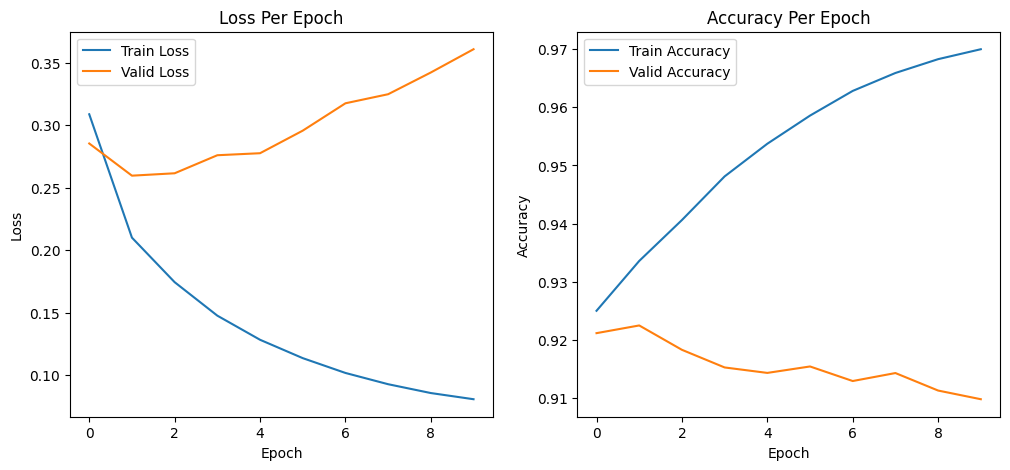

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
def calculate_f1(model, loader, label_dict):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for texts, verb_indices, label_batch in loader:
            texts, verb_indices, label_batch = texts.to(device), verb_indices.to(device), label_batch.to(device)
            outputs = model(texts, verb_indices)
            pred_labels = outputs.argmax(dim=2).cpu().numpy()
            labels_numpy = label_batch.cpu().numpy()
            true_labels.extend(labels_numpy.flatten())
            predictions.extend(pred_labels.flatten())

    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=1)

    return f1

f1_valid = calculate_f1(model, valid_loader, labels)
print(f'Validation F1 Score : {f1_valid:.4f}')


Validation F1 Score : 0.9084


In [19]:
import torch

def train_model_mask(model, train_loader, valid_loader, optimizer, loss_function, num_epochs, device):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        total_train_elements = 0

        for texts, verb_indices, labels in train_loader:
            texts, verb_indices, labels = texts.to(device), verb_indices.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts, verb_indices)
            outputs_flat = outputs.view(-1, outputs.shape[-1])
            labels_flat = labels.view(-1)

            loss = loss_function(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            mask = labels_flat != 0  # padding tokens are labeled with 0
            correct_predictions = (outputs_flat.argmax(1) == labels_flat) & mask
            total_train_accuracy += correct_predictions.float().sum().item()
            total_train_elements += mask.sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / total_train_elements

        # Validation
        model.eval()
        total_valid_loss = 0
        total_valid_accuracy = 0
        total_valid_elements = 0

        with torch.no_grad():
            for texts, verb_indices, labels in valid_loader:
                texts, verb_indices, labels = texts.to(device), verb_indices.to(device), labels.to(device)
                outputs = model(texts, verb_indices)
                outputs_flat = outputs.view(-1, outputs.shape[-1])
                labels_flat = labels.view(-1)

                loss = loss_function(outputs_flat, labels_flat)
                total_valid_loss += loss.item()

                mask = labels_flat != 0  # padding tokens are labeled with 0
                correct_predictions = (outputs_flat.argmax(1) == labels_flat) & mask
                total_valid_accuracy += correct_predictions.float().sum().item()
                total_valid_elements += mask.sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        avg_valid_accuracy = total_valid_accuracy / total_valid_elements

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_accuracy)
        history['valid_loss'].append(avg_valid_loss)
        history['valid_acc'].append(avg_valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {avg_train_accuracy:.4f}, '
              f'Valid Loss = {avg_valid_loss:.4f}, Valid Acc = {avg_valid_accuracy:.4f}')

    return history


In [100]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_mask(model, loader, device):
    model.eval()
    ignore_label=0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for texts, verb_indices, label_batch in loader:
            texts, verb_indices, label_batch = texts.to(device), verb_indices.to(device), label_batch.to(device)
            outputs = model(texts, verb_indices)
            pred_labels = outputs.argmax(dim=2).cpu().numpy()
            labels_numpy = label_batch.cpu().numpy()

            pred_flat = pred_labels.flatten()
            labels_flat = labels_numpy.flatten()

            valid_indices = labels_flat != ignore_label
            filtered_labels = labels_flat[valid_indices]
            filtered_predictions = pred_flat[valid_indices]

            true_labels.extend(filtered_labels)
            predictions.extend(filtered_predictions)

    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=1)

    return f1

## Train Model with Ignore Index 0 for loss

In [39]:
lstm_model = SRLModel_LSTM(len(vocab), embedding_dim=64, hidden_dim=64, num_tags=len(labels))
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss(ignore_index=0)  # '0' is the label for padding

num_epochs = 15
history = train_model_mask(lstm_model, train_loader, valid_loader, optimizer, loss_function, num_epochs, device)

Epoch 1/15: Train Loss = 1.0802, Train Acc = 0.6108, Valid Loss = 0.9613, Valid Acc = 0.6484
Epoch 2/15: Train Loss = 0.6339, Train Acc = 0.7812, Valid Loss = 0.9189, Valid Acc = 0.6989
Epoch 3/15: Train Loss = 0.4039, Train Acc = 0.8665, Valid Loss = 0.9830, Valid Acc = 0.6916
Epoch 4/15: Train Loss = 0.2632, Train Acc = 0.9153, Valid Loss = 1.0492, Valid Acc = 0.6894
Epoch 5/15: Train Loss = 0.1759, Train Acc = 0.9440, Valid Loss = 1.1409, Valid Acc = 0.7021
Epoch 6/15: Train Loss = 0.1250, Train Acc = 0.9607, Valid Loss = 1.2685, Valid Acc = 0.6980
Epoch 7/15: Train Loss = 0.0916, Train Acc = 0.9726, Valid Loss = 1.3414, Valid Acc = 0.6977
Epoch 8/15: Train Loss = 0.0740, Train Acc = 0.9774, Valid Loss = 1.4546, Valid Acc = 0.7053
Epoch 9/15: Train Loss = 0.0643, Train Acc = 0.9796, Valid Loss = 1.4968, Valid Acc = 0.6973
Epoch 10/15: Train Loss = 0.0505, Train Acc = 0.9848, Valid Loss = 1.5047, Valid Acc = 0.7069
Epoch 11/15: Train Loss = 0.0410, Train Acc = 0.9879, Valid Loss = 1.

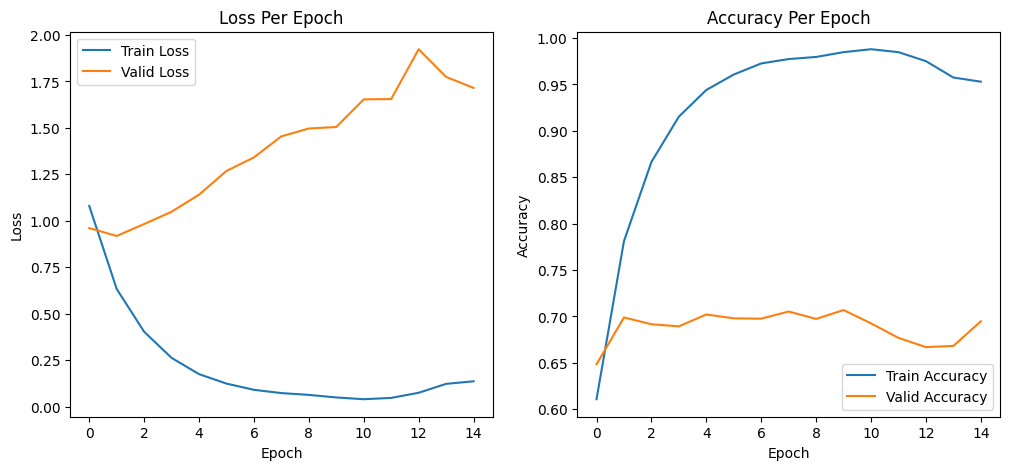

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
f1_valid = calculate_f1_mask(lstm_model, valid_loader, device)
print(f'Validation F1 Score: {f1_valid:.4f}')


Validation F1 Score: 0.6942


#Part3 :  GRU Encoder Model

In [91]:
class SRLModel_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):
        super(SRLModel_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_tags)

    def forward(self, x, verb_indices):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        verb_hidden_states = gru_out[range(len(verb_indices)), verb_indices]
        verb_hidden_states = verb_hidden_states.unsqueeze(1).expand(-1, gru_out.size(1), -1)
        gru_concat = torch.cat((gru_out, verb_hidden_states), dim=-1)
        srl_tags = self.classifier(gru_concat)
        return srl_tags


In [ ]:
model = SRLModel_GRU(len(vocab), embedding_dim=64, hidden_dim=64, num_tags=len(labels))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()
num_epochs = 10
history = train_model(model, train_loader, valid_loader, optimizer, loss_function, num_epochs)


Epoch 1/10: Train Loss = 0.3377, Train Acc = 0.9192, Valid Loss = 0.3284, Valid Acc = 0.9207
Epoch 2/10: Train Loss = 0.2754, Train Acc = 0.9267, Valid Loss = 0.3309, Valid Acc = 0.9125
Epoch 3/10: Train Loss = 0.2834, Train Acc = 0.9244, Valid Loss = 0.3721, Valid Acc = 0.9110
Epoch 4/10: Train Loss = 0.2989, Train Acc = 0.9227, Valid Loss = 0.3668, Valid Acc = 0.9129
Epoch 5/10: Train Loss = 0.3426, Train Acc = 0.9180, Valid Loss = 0.4262, Valid Acc = 0.8953
Epoch 6/10: Train Loss = 0.3553, Train Acc = 0.9200, Valid Loss = 0.4153, Valid Acc = 0.9147
Epoch 7/10: Train Loss = 0.3500, Train Acc = 0.9209, Valid Loss = 0.3924, Valid Acc = 0.9203
Epoch 8/10: Train Loss = 0.3530, Train Acc = 0.9202, Valid Loss = 0.3934, Valid Acc = 0.9107
Epoch 9/10: Train Loss = 0.3548, Train Acc = 0.9203, Valid Loss = 0.4220, Valid Acc = 0.9178
Epoch 10/10: Train Loss = 0.3628, Train Acc = 0.9214, Valid Loss = 0.3964, Valid Acc = 0.9192


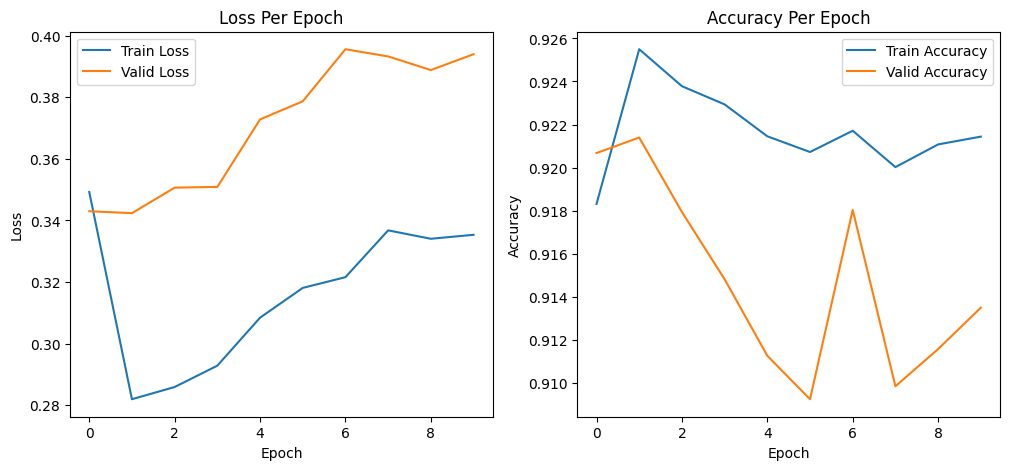

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
f1_valid = calculate_f1(model, valid_loader, labels)
print(f'Validation F1 Score : {f1_valid:.4f}')

Validation F1 Score : 0.8847


## Train Model with Ignore Index 0 for loss

In [93]:
gru_model = SRLModel_GRU(len(vocab), embedding_dim=64, hidden_dim=64, num_tags=len(labels))
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss(ignore_index=0)  # '0' is the label for padding

num_epochs = 15
history = train_model_mask(gru_model, train_loader, valid_loader, optimizer, loss_function, num_epochs, device)

Epoch 1/15: Train Loss = 1.0771, Train Acc = 0.6114, Valid Loss = 0.9573, Valid Acc = 0.6718
Epoch 2/15: Train Loss = 0.6483, Train Acc = 0.7774, Valid Loss = 0.9851, Valid Acc = 0.6804
Epoch 3/15: Train Loss = 0.4437, Train Acc = 0.8532, Valid Loss = 1.0158, Valid Acc = 0.6830
Epoch 4/15: Train Loss = 0.3184, Train Acc = 0.8943, Valid Loss = 1.1396, Valid Acc = 0.6913
Epoch 5/15: Train Loss = 0.2330, Train Acc = 0.9232, Valid Loss = 1.1716, Valid Acc = 0.7028
Epoch 6/15: Train Loss = 0.1961, Train Acc = 0.9352, Valid Loss = 1.3147, Valid Acc = 0.6798
Epoch 7/15: Train Loss = 0.1714, Train Acc = 0.9431, Valid Loss = 1.3741, Valid Acc = 0.6814
Epoch 8/15: Train Loss = 0.1626, Train Acc = 0.9450, Valid Loss = 1.5295, Valid Acc = 0.6804
Epoch 9/15: Train Loss = 0.1545, Train Acc = 0.9497, Valid Loss = 1.5721, Valid Acc = 0.6753
Epoch 10/15: Train Loss = 0.1558, Train Acc = 0.9468, Valid Loss = 1.5860, Valid Acc = 0.6734
Epoch 11/15: Train Loss = 0.1677, Train Acc = 0.9431, Valid Loss = 1.

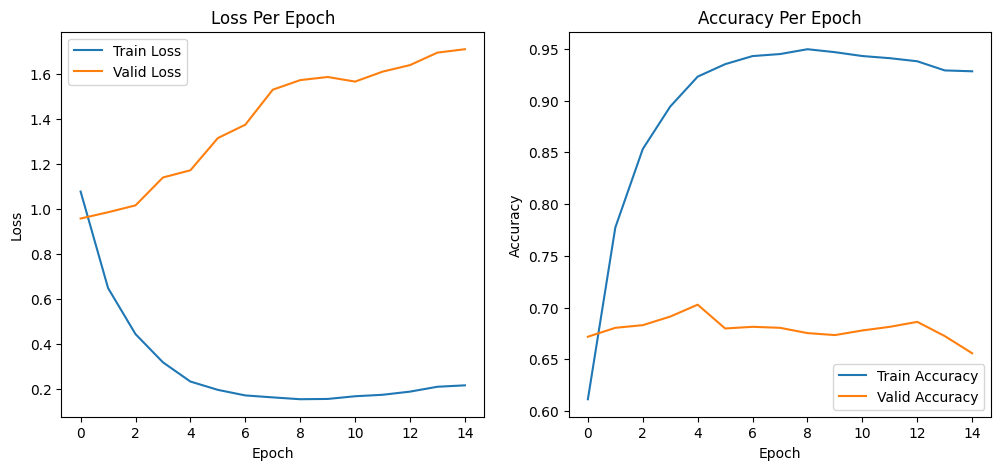

In [103]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [102]:
f1_valid = calculate_f1_mask(gru_model, valid_loader, device)
print(f'Validation F1 Score: {f1_valid:.4f}')

Validation F1 Score: 0.6568


#Part4: Encoder-Decoder Model

In [104]:
file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/train.json'

with open(file_path, 'r') as file:
    train_data = json.load(file)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/valid.json'

with open(file_path, 'r') as file:
    valid_data = json.load(file)

file_path = '/content/gdrive/MyDrive/Colab Notebooks/NLP CA3/test.json'

with open(file_path, 'r') as file:
    test_data = json.load(file)

In [105]:
def create_qa_pairs(data):
    all_labels = ['ARG0', 'ARG1', 'ARG2', 'ARGM-TMP', 'ARGM-LOC']
    qa_pairs = []
    for i, sentence in enumerate(data['text']):
        verb = sentence[data['verb_index'][i]]
        sentence_str = ' '.join(sentence)
        label_answers = {label: "<s> </s>" for label in all_labels}

        for j, role in enumerate(data['srl_frames'][i]):
            if role.startswith('B-'):
                role_type = role.split('-')[1]
                content = [sentence[j]]
                k = j + 1
                while k < len(data['srl_frames'][i]) and data['srl_frames'][i][k] == f"I-{role_type}":
                    content.append(sentence[k])
                    k += 1
                label_answers[role_type] = f"<s> {' '.join(content)} </s>"

        for label in all_labels:
            question = f"{verb} [SEPT] {sentence_str} {label}"
            answer = label_answers[label]
            qa_pairs.append((question, answer))

    return qa_pairs

qa_train = create_qa_pairs(train_data)
qa_valid = create_qa_pairs(valid_data)
#qa_test= create_qa_pairs(test_data)

In [106]:
qa_train[1]

('inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG1',
 '<s> steles </s>')

In [ ]:
#!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
#!unzip glove*.zip

--2024-05-06 21:32:54--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.24, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1715290374&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTI5MDM3NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=waeiIvnR5k9EBi54p4yBuXPvYZ

In [ ]:
"""
import zipfile
path = '/content/gdrive/MyDrive/Dataset/'
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
"""

In [107]:
path = "/content/gdrive/MyDrive/Dataset/glove.6B.300d.txt"
embeddings_dict = {}
with open(path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

In [108]:
vocab = Vocab()
vocab.from_corpus(train_data['text'], size=20000, remove_frac=0.3, freq_cutoff=1)

In [109]:
embedding_dim = 300
embedding_matrix = np.zeros((len(vocab.word2id) + 1, embedding_dim))
for word, i in vocab.word2id.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

##Model

In [110]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix, bidirectional=True):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=bidirectional, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1).unsqueeze(0)
            cell = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1).unsqueeze(0)
        return outputs, (hidden, cell)


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden.repeat(src_len, 1, 1).permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, embedding_matrix, bidirectional_encoder=True):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.attention = Attention(hidden_dim, hidden_dim * (2 if bidirectional_encoder else 1))
        self.lstm = nn.LSTM(embedding_dim + hidden_dim * 2, hidden_dim * (2 if bidirectional_encoder else 1), batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * (2 if bidirectional_encoder else 1), output_dim)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).unsqueeze(1)
        attention_weights = self.attention(hidden[0].squeeze(0), encoder_outputs)

        weighted = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        lstm_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.lstm(lstm_input, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

    def forward_step(self, input_tensor, hidden_state, encoder_outputs):

        embedded = self.embedding(input_tensor).unsqueeze(1)

        hidden, cell = hidden_state
        attention_weights = self.attention(hidden.squeeze(0), encoder_outputs)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        lstm_input = torch.cat((embedded, context_vector), dim=2)
        output, new_hidden_state = self.lstm(lstm_input, hidden_state)
        prediction = self.fc_out(output.squeeze(1))

        return prediction, new_hidden_state

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

    def forward(self, src, trg):
        encoder_outputs, hidden = self.encoder(src)
        outputs = []
        input = trg[:,0]
        for t in range(1, trg.size(1)):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs.append(output)
            input = output.argmax(1)
        return torch.stack(outputs, dim=1)

In [111]:
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def tokenize_and_numericalize(qa_pairs, vocab):
    tokenized_data = []
    for question, answer in qa_pairs:
        question_indices = vocab.word2indices([question.split()])
        answer_indices = vocab.word2indices([answer.split()])
        tokenized_data.append((question_indices[0], answer_indices[0]))
    return tokenized_data

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    questions, answers = zip(*batch)
    questions_padded = pad_sequence([torch.tensor(q) for q in questions], batch_first=True, padding_value=vocab.word2id['<pad>'])
    answers_padded = pad_sequence([torch.tensor(a) for a in answers], batch_first=True, padding_value=vocab.word2id['<pad>'])
    return questions_padded, answers_padded

qa_train_tokenized = tokenize_and_numericalize(qa_train, vocab)
qa_valid_tokenized = tokenize_and_numericalize(qa_valid, vocab)


train_dataset = QADataset(qa_train_tokenized)
valid_dataset = QADataset(qa_valid_tokenized)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
qa_train[1]

('inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG1',
 '<s> steles </s>')

In [ ]:
train_dataset[1]

([11660,
  3,
  129,
  3401,
  11659,
  10,
  185,
  8394,
  8395,
  10,
  14,
  100,
  11660,
  8395,
  12,
  6],
 [1, 8395, 2])

In [112]:
def train_model(model, train_loader, valid_loader, optimizer, loss_function, num_epochs):
    model = model.to(device)
    writer = SummaryWriter()
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg)

            output_dim = output.shape[-1]
            output = output[:, :-1].reshape(-1, output_dim)
            trg = trg[:, 1:-1].reshape(-1)

            loss = loss_function(output, trg)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += (output.argmax(1) == trg).float().mean().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)

        # Validation
        model.eval()
        total_valid_loss = 0
        total_valid_accuracy = 0
        with torch.no_grad():
            for src, trg in valid_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output_dim = output.shape[-1]
                output = output[:, :-1].reshape(-1, output_dim)
                trg = trg[:, 1:-1].reshape(-1)

                loss = loss_function(output, trg)
                total_valid_loss += loss.item()
                total_valid_accuracy += (output.argmax(1) == trg).float().mean().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        avg_valid_accuracy = total_valid_accuracy / len(valid_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_accuracy)
        history['valid_loss'].append(avg_valid_loss)
        history['valid_acc'].append(avg_valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Train Acc = {avg_train_accuracy:.4f}, '
              f'Valid Loss = {avg_valid_loss:.4f}, Valid Acc = {avg_valid_accuracy:.4f}')

        writer.add_scalars('Loss', {'train': avg_train_loss, 'valid': avg_valid_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': avg_train_accuracy, 'valid': avg_valid_accuracy}, epoch)

    writer.close()
    return history

In [ ]:
encoder = Encoder(vocab_size=len(vocab), embedding_dim=300, hidden_dim=64, embedding_matrix=embedding_matrix, bidirectional=True).to(device)
decoder = Decoder(embedding_dim=300, hidden_dim=64, output_dim=len(vocab), embedding_matrix=embedding_matrix, bidirectional_encoder=True).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
history = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10: Train Loss = 1.3840, Train Acc = 0.8188, Valid Loss = 1.1959, Valid Acc = 0.8234
Epoch 2/10: Train Loss = 1.2672, Train Acc = 0.8218, Valid Loss = 1.1753, Valid Acc = 0.8265
Epoch 3/10: Train Loss = 1.2431, Train Acc = 0.8254, Valid Loss = 1.1709, Valid Acc = 0.8264
Epoch 4/10: Train Loss = 1.2312, Train Acc = 0.8248, Valid Loss = 1.1627, Valid Acc = 0.8259
Epoch 5/10: Train Loss = 1.2330, Train Acc = 0.8229, Valid Loss = 1.1569, Valid Acc = 0.8255
Epoch 6/10: Train Loss = 1.2132, Train Acc = 0.8246, Valid Loss = 1.1764, Valid Acc = 0.8177
Epoch 7/10: Train Loss = 1.2165, Train Acc = 0.8241, Valid Loss = 1.1431, Valid Acc = 0.8270
Epoch 8/10: Train Loss = 1.2002, Train Acc = 0.8249, Valid Loss = 1.1165, Valid Acc = 0.8301
Epoch 9/10: Train Loss = 1.1919, Train Acc = 0.8253, Valid Loss = 1.1352, Valid Acc = 0.8247
Epoch 10/10: Train Loss = 1.2098, Train Acc = 0.8232, Valid Loss = 1.1676, Valid Acc = 0.8175


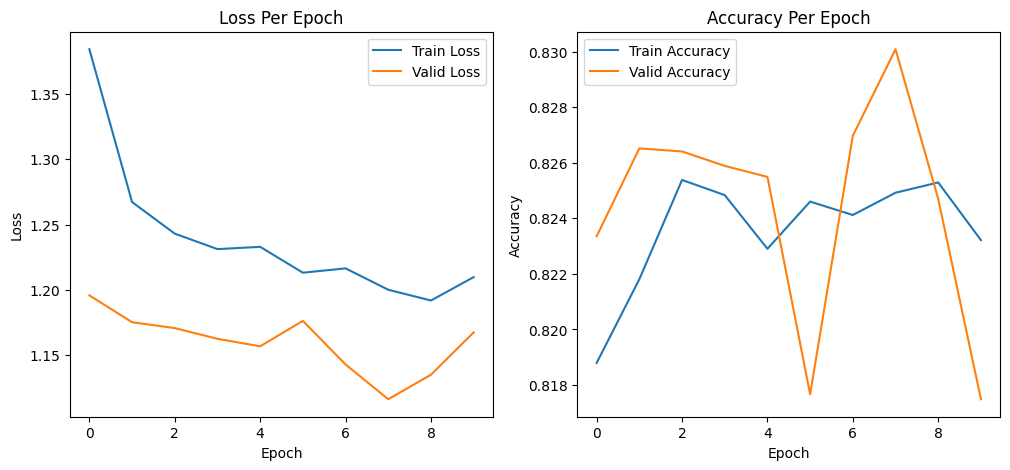

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [119]:
def calculate_f1_seq2seq(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for src, trg in valid_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, :-1].reshape(-1, output_dim)
            trg = trg[:, 1:-1].reshape(-1)
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(trg.cpu().numpy())
    f1 = f1_score(all_trues, all_preds, average='weighted')
    return f1

In [ ]:
f1_score = calculate_f1_seq2seq(model, valid_loader, device)
print("F1 Score on validation set:", f1_score)


F1 Score on validation set: 0.7849972284224219


In [113]:
class Beam:
    def __init__(self, tokens, log_prob, hidden, cell):
        self.tokens = tokens
        self.log_prob = log_prob
        self.hidden = hidden
        self.cell = cell

def beam_search(model, input_text, vocab, beam_size=16, max_len=50):
    model.eval()
    with torch.no_grad():
        tokens = input_text.split()
        src_indices = [vocab.word2id.get(token, vocab.word2id['<unk>']) for token in tokens]
        src_tensor = torch.tensor([src_indices], dtype=torch.long).to(model.device)
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
        beams = [Beam(tokens=[vocab.word2id['<s>']], log_prob=0.0, hidden=hidden, cell=cell)]

        for _ in range(max_len):
            new_beams = []
            for beam in beams:
                input_tensor = torch.tensor([beam.tokens[-1]], dtype=torch.long).to(model.device)
                prediction, (new_hidden, new_cell) = model.decoder.forward_step(input_tensor, (beam.hidden, beam.cell), encoder_outputs)
                log_probs = F.log_softmax(prediction, dim=1)

                top_probs, top_indices = torch.topk(log_probs, beam_size, dim=1)

                for i in range(beam_size):
                    token = top_indices[0][i].item()
                    log_prob = top_probs[0][i].item()

                    new_beam = Beam(
                        tokens=beam.tokens + [token],
                        log_prob=beam.log_prob + log_prob,
                        hidden=new_hidden,
                        cell=new_cell
                    )
                    new_beams.append(new_beam)

            new_beams.sort(key=lambda b: b.log_prob, reverse=True)
            beams = new_beams[:beam_size]

            if beams[0].tokens[-1] == vocab.word2id['</s>']:
                break

        best_beam = beams[0]
        decoded_words = [vocab.id2word[t] for t in best_beam.tokens]
        return ' '.join(decoded_words)


In [ ]:
# Test Beam Search with trained data
qa_train[1]

('inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG1',
 '<s> steles </s>')

In [ ]:
output_text = beam_search(model, "inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG0", vocab, beam_size=16, max_len=10)
print(output_text)

<s> steles </s>


# Train Seq2Seq model with ignore index 0

In [116]:
encoder = Encoder(vocab_size=len(vocab), embedding_dim=300, hidden_dim=64, embedding_matrix=embedding_matrix, bidirectional=True).to(device)
decoder = Decoder(embedding_dim=300, hidden_dim=64, output_dim=len(vocab), embedding_matrix=embedding_matrix, bidirectional_encoder=True).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 10
history = train_model(model, train_loader, valid_loader, optimizer, loss_function, num_epochs)

Epoch 1/10: Train Loss = 3.2395, Train Acc = 0.2065, Valid Loss = 2.8160, Valid Acc = 0.2138
Epoch 2/10: Train Loss = 2.7628, Train Acc = 0.2124, Valid Loss = 2.5835, Valid Acc = 0.2190
Epoch 3/10: Train Loss = 2.5616, Train Acc = 0.2176, Valid Loss = 2.3774, Valid Acc = 0.2237
Epoch 4/10: Train Loss = 2.3675, Train Acc = 0.2230, Valid Loss = 2.1717, Valid Acc = 0.2296
Epoch 5/10: Train Loss = 2.1805, Train Acc = 0.2296, Valid Loss = 1.9863, Valid Acc = 0.2317
Epoch 6/10: Train Loss = 2.0029, Train Acc = 0.2301, Valid Loss = 1.7895, Valid Acc = 0.2403
Epoch 7/10: Train Loss = 1.8169, Train Acc = 0.2363, Valid Loss = 1.6197, Valid Acc = 0.2415
Epoch 8/10: Train Loss = 1.6282, Train Acc = 0.2431, Valid Loss = 1.4071, Valid Acc = 0.2520
Epoch 9/10: Train Loss = 1.4479, Train Acc = 0.2506, Valid Loss = 1.2287, Valid Acc = 0.2592
Epoch 10/10: Train Loss = 1.2751, Train Acc = 0.2574, Valid Loss = 1.0612, Valid Acc = 0.2679


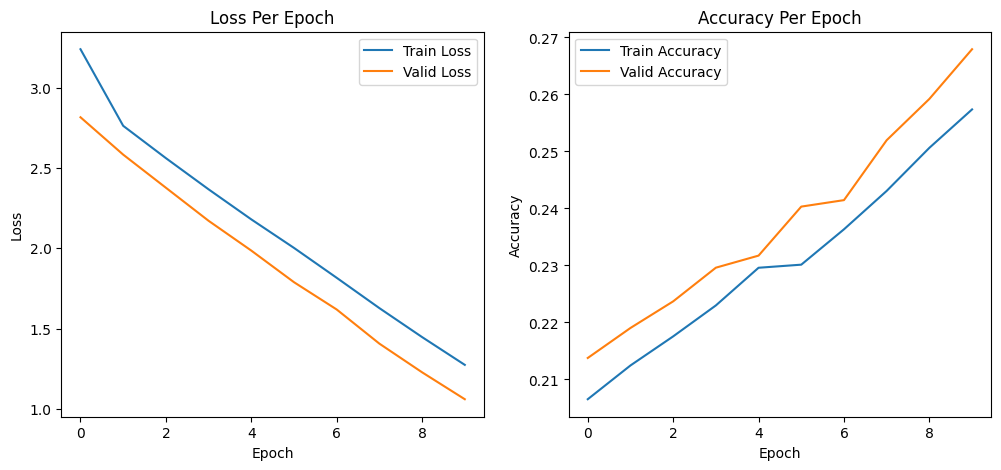

In [117]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Valid Accuracy')
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [120]:
f1_score = calculate_f1_seq2seq(model, valid_loader, device)
print("F1 Score on validation set:", f1_score)


F1 Score on validation set: 0.109332693451754


## Check BeamSearch on Train data

In [127]:
qa_train[1]

('inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG1',
 '<s> steles </s>')

In [128]:
output_text = beam_search(model, "inscribed [SEPT] A primary stele , three secondary steles , and two inscribed steles . ARG1", vocab, beam_size=16, max_len=10)
print(output_text)

<s> steles </s>


##Check BeamSearch on Unseen data

In [137]:
qa_valid[6]

('is [SEPT] The most important thing about Disney is that it is a global brand . ARG1',
 '<s> it </s>')

In [138]:
output_text = beam_search(model, "is [SEPT] The most important thing about Disney is that it is a global brand . ARG1", vocab, beam_size=16, max_len=10)
print(output_text)

<s> it <unk> </s>


## Part 5:

## Classification Report of LSTM Model

In [88]:
def evaluate_model(model, loader, device, label_dict):
    ignore_label = 'O'
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for texts, verb_indices, label_batch in loader:
            texts, verb_indices, label_batch = texts.to(device), verb_indices.to(device), label_batch.to(device)
            outputs = model(texts, verb_indices)
            pred_labels = outputs.argmax(dim=2).cpu().numpy()
            labels_numpy = label_batch.cpu().numpy()

            pred_flat = pred_labels.flatten()
            labels_flat = labels_numpy.flatten()

            valid_indices = labels_flat != label_dict[ignore_label]
            filtered_labels = labels_flat[valid_indices]
            filtered_predictions = pred_flat[valid_indices]

            true_labels.extend(filtered_labels)
            predictions.extend(filtered_predictions)

    label_names = [label for label in label_dict if label != ignore_label]
    label_indices = [label_dict[label] for label in label_names]

    class_report = classification_report(true_labels, predictions, labels=label_indices, target_names=label_names, zero_division=1)
    print("Classification Report:\n", class_report)

    cm = confusion_matrix(true_labels, predictions, labels=label_indices)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return class_report

Classification Report:
               precision    recall  f1-score   support

      B-ARG0       0.80      0.37      0.51       357
      I-ARG0       0.68      0.25      0.37       287
      B-ARG1       0.77      0.36      0.49       662
      I-ARG1       0.79      0.27      0.40      1032
      B-ARG2       0.81      0.39      0.53       219
      I-ARG2       0.84      0.36      0.51       493
  B-ARGM-LOC       1.00      0.10      0.18        10
  I-ARGM-LOC       1.00      1.00      1.00         0
  B-ARGM-TMP       0.86      0.45      0.59        69
  I-ARGM-TMP       1.00      1.00      1.00         0

   micro avg       0.79      0.32      0.46      3129
   macro avg       0.86      0.46      0.56      3129
weighted avg       0.79      0.32      0.46      3129



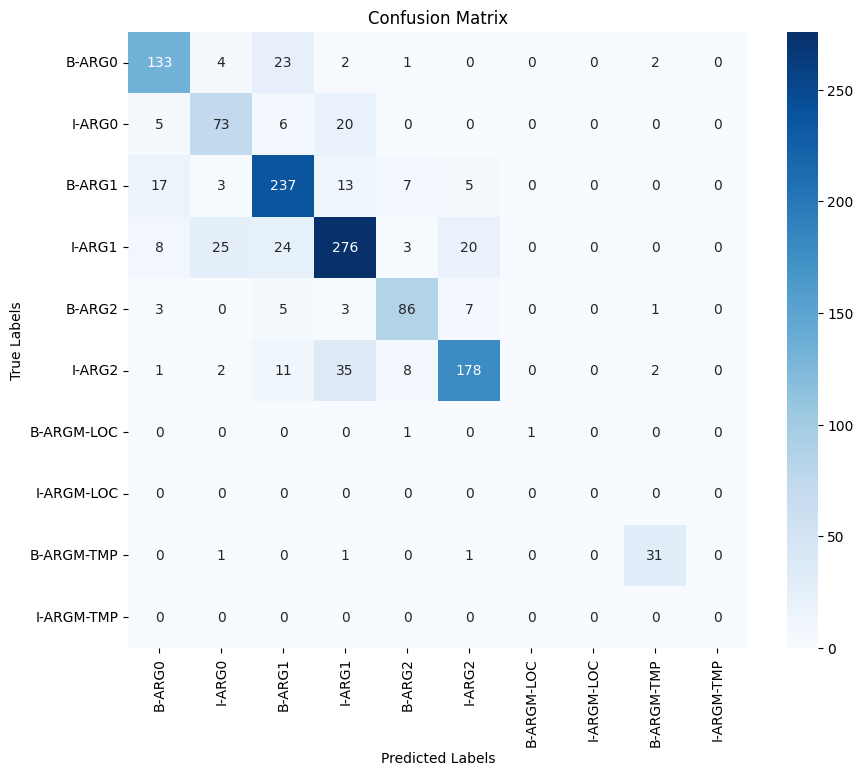

In [89]:
class_report = evaluate_model(lstm_model, valid_loader, device, labels)

In [ ]:
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for src, trg in valid_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, :-1].reshape(-1, output_dim)
            trg = trg[:, 1:-1].reshape(-1)
            preds = output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(trg.cpu().numpy())

    print("Classification Report:\n", classification_report(all_trues, all_preds, zero_division=1))

    cm = confusion_matrix(all_trues, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
class_report = evaluate_model(model, valid_loader, device)